In [1]:
import os, json, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles

# -----------------------
# Utilities
# -----------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def sem(x):
    x = np.asarray(x, dtype=float)
    if len(x) <= 1: 
        return 0.0
    return x.std(ddof=1) / np.sqrt(len(x))

# -----------------------
# Synthetic generator (mirrors your notebook)
# -----------------------
@torch.no_grad()
def generate_synthetic(T_rec=10, S=5, K=40, N=50, rank=3, device="cpu"):
    """
    Returns dict with W0,U,V,z_true,x,v and some fixed bias a (your 'a' / b_fixed).
    This mirrors your current synthetic construction: W0 random, U/V from SVD(W0),
    z_true as sinusoids, then simulate x with tanh.
    """
    # Base weights and low-rank modes
    W0 = 0.0005 * torch.randn(N, N, device=device)
    U_full, _, Vt_full = torch.linalg.svd(W0)
    U = U_full[:, :rank].contiguous()
    V = Vt_full[:rank, :].T.contiguous()

    # Input & decoder (as in your notebook)
    B = 0.05 * torch.randn(N, 1, device=device)
    b_fixed = 0.1 * torch.randn(N, device=device)   # this corresponds to your "a"
    R = 0.05 * torch.randn(1, N, device=device)     # linear readout

    # True latent drift
    t_vals = torch.linspace(0, 2*np.pi, T_rec, device=device)
    z_true = torch.stack(
        [torch.sin(t_vals + np.pi*i/rank) + 0.1*t_vals for i in range(rank)],
        dim=1
    )  # [T_rec, rank]

    # Build W(t) true
    Ws_true = []
    for t in range(T_rec):
        Ws_true.append(W0 + U @ torch.diag(z_true[t]) @ V.T)
    Ws_true = torch.stack(Ws_true, dim=0)  # [T_rec, N, N]

    # Generate v and x by simulating the RNN
    v = torch.zeros(T_rec, S, K, device=device)
    x = torch.zeros(T_rec, S, K, N, device=device)

    # velocity input: simple smooth random per-trial signal
    for t in range(T_rec):
        for s in range(S):
            base = torch.sin(torch.linspace(0, 3*np.pi, K, device=device) + 0.3*torch.randn(1, device=device))
            v[t, s] = base + 0.05 * torch.randn(K, device=device)

            # init state
            x_prev = 0.1 * torch.randn(N, device=device)
            x[t, s, 0] = x_prev

            Wt = Ws_true[t]
            for k in range(K-1):
                x_next = torch.tanh(Wt @ x_prev + (B * v[t, s, k]).squeeze() + b_fixed)
                x[t, s, k+1] = x_next
                x_prev = x_next

    return dict(
        T_rec=T_rec, S=S, K=K, N=N, rank=rank,
        W0=W0, U=U, V=V, B=B, R=R, b_fixed=b_fixed,
        z_true=z_true, Ws_true=Ws_true,
        x=x, v=v
    )

# -----------------------
# Dataset/Loader (days 0..T_train-1)
# -----------------------
class DayTrialDataset(Dataset):
    def __init__(self, x, v, T_train):
        """
        x: [T_rec,S,K,N], v: [T_rec,S,K]
        returns items: (x_trial [K,N], v_trial [K], day_idx int)
        """
        self.items = []
        T_rec, S = x.shape[0], x.shape[1]
        for t in range(T_train):
            for s in range(S):
                self.items.append((t, s))
        self.x = x
        self.v = v

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        t, s = self.items[idx]
        return self.x[t, s], self.v[t, s], torch.tensor(t, dtype=torch.long)

def make_loader(x, v, T_train, batch_size=4, shuffle=True):
    ds = DayTrialDataset(x, v, T_train=T_train)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# -----------------------
# Model (parameterized so we can change rank cleanly)
# -----------------------
class SlowODE(nn.Module):
    def __init__(self, rank, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(rank + 1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, rank)
        )

    def forward(self, t, z):
        # concatenate time (scalar) to state
        if z.ndim == 1:
            z_in = z
        else:
            z_in = z.squeeze(0)
        t_in = torch.ones_like(z_in[:1]) * t
        inp = torch.cat([z_in, t_in], dim=0)
        dz = self.net(inp)
        return dz

class PINN(nn.Module):
    def __init__(self, W0, U, V, B, R, b_fixed, K):
        super().__init__()
        self.W0 = nn.Parameter(W0.clone(), requires_grad=False)  # keep fixed like your notebook
        self.U  = nn.Parameter(U.clone(),  requires_grad=False)
        self.V  = nn.Parameter(V.clone(),  requires_grad=False)

        rank = U.shape[1]
        self.z0 = nn.Parameter(torch.zeros(rank, device=W0.device))
        self.slow = SlowODE(rank).to(W0.device)

        self.B = nn.Parameter(B.clone())
        self.R = nn.Parameter(R.clone())
        self.b_fixed = nn.Parameter(b_fixed.clone(), requires_grad=False)
        self.K = K

    def weights(self, T):
        times = torch.arange(T, dtype=torch.float32, device=self.W0.device)
        z = odeint(self.slow, self.z0, times)  # [T, rank]
        # build W(t) for all t
        # W(t) = W0 + U diag(z_t) V^T
        Ws = self.W0.unsqueeze(0) + torch.einsum("nr,tr, mr->tnm", self.U, z, self.V)
        return Ws  # [T,N,N]

    def rnn_cell(self, xk, vk, W):
        return torch.tanh(W @ xk + (self.B * vk).squeeze() + self.b_fixed)

    def forward_trial(self, x0, v_seq, day_idx, Ws):
        """
        x0: [K,N] observed, v_seq:[K], Ws:[T,N,N]
        returns recon MSE + decoder MSE (as in your notebook)
        """
        W = Ws[day_idx]
        rec = 0.0
        dec = 0.0
        x_prev = x0[0]
        for k in range(self.K - 1):
            x_pred = self.rnn_cell(x_prev, v_seq[k], W)
            rec = rec + (x_pred - x0[k+1]).pow(2).mean()
            dec = dec + (self.R @ x_pred - v_seq[k]).pow(2).mean()
            x_prev = x_pred
        return rec + 0.1 * dec

# -----------------------
# Train + Evaluate
# -----------------------
def train_one_rank(data, T_train=4, epochs=300, lr=1e-3, batch_size=4, device="cpu", verbose=False):
    loader = make_loader(data["x"], data["v"], T_train=T_train, batch_size=batch_size, shuffle=True)

    model = PINN(
        W0=data["W0"], U=data["U"], V=data["V"],
        B=data["B"], R=data["R"], b_fixed=data["b_fixed"], K=data["K"]
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        L = 0.0
        for xb, vb, tb in loader:
            xb = xb.to(device)           # [B,K,N]
            vb = vb.to(device)           # [B,K]
            tb = tb.to(device)           # [B]
            Ws = model.weights(data["T_rec"])

            # compute mean loss across batch
            loss = torch.stack([model.forward_trial(xb[i], vb[i], tb[i], Ws) for i in range(xb.size(0))]).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
            L += loss.item()

        if verbose and (ep % 50 == 0 or ep == epochs-1):
            print(f"ep {ep:4d} | loss {L/len(loader):.4f}")

    return model

@torch.no_grad()
def eval_model(data, model, test_day=6, trial_idx=0, subspace_k=5):
    """
    Returns metrics for one held-out day (by default day 6).
    """
    device = next(model.parameters()).device
    Ws_pred = model.weights(data["T_rec"]).detach()            # [T,N,N]
    W_pred  = Ws_pred[test_day]
    W_true  = data["Ws_true"][test_day].to(device)

    # Simulate one trial using TRUE v, compare to true x
    v_seq = data["v"][test_day, trial_idx].to(device)          # [K]
    x_true = data["x"][test_day, trial_idx].to(device)         # [K,N]

    # rollout
    K = data["K"]
    x_pred = torch.zeros_like(x_true)
    x_prev = x_true[0]
    x_pred[0] = x_prev
    for k in range(K-1):
        x_next = model.rnn_cell(x_prev, v_seq[k], W_pred)
        x_pred[k+1] = x_next
        x_prev = x_next

    act_mse = torch.mean((x_pred - x_true)**2).item()
    dec_mse = torch.mean(( (model.R @ x_pred.T).squeeze() - v_seq )**2).item()

    # Weight correlation (element-wise)
    w_true_flat = W_true.flatten().detach().cpu().numpy()
    w_pred_flat = W_pred.flatten().detach().cpu().numpy()
    w_corr = float(np.corrcoef(w_true_flat, w_pred_flat)[0,1])

    # Subspace angle (top-k right singular vectors)
    # angle in degrees: mean principal angle between k-dim subspaces
    _, _, Vt1 = torch.linalg.svd(W_true)
    _, _, Vt2 = torch.linalg.svd(W_pred)
    A = Vt1[:subspace_k].T.detach().cpu().numpy()
    B = Vt2[:subspace_k].T.detach().cpu().numpy()
    ang = subspace_angles(A, B)                 # radians
    subspace_angle_deg = float(np.mean(ang) * 180/np.pi)

    return dict(
        act_mse=act_mse,
        dec_mse=dec_mse,
        w_corr=w_corr,
        subspace_angle_deg=subspace_angle_deg
    )

# -----------------------
# Rank sweep (THIS is what you asked for)
# -----------------------
def rank_sweep(
    ranks,
    seeds=(0,1,2),
    T_rec=10, S=5, K=40, N=50,
    T_train=4, test_day=6,
    epochs=300, lr=1e-3, batch_size=4,
    subspace_k=5,
    device=None,
    save_dir="rank_sweep_outputs",
    verbose=False
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    rows = []
    for r in ranks:
        per_seed = []
        for seed in seeds:
            set_seed(seed)

            data = generate_synthetic(T_rec=T_rec, S=S, K=K, N=N, rank=r, device=device)
            model = train_one_rank(
                data, T_train=T_train, epochs=epochs, lr=lr, batch_size=batch_size,
                device=device, verbose=verbose
            )
            metrics = eval_model(data, model, test_day=test_day, trial_idx=0, subspace_k=subspace_k)
            metrics.update(dict(rank=r, seed=seed))
            rows.append(metrics)
            per_seed.append(metrics)

        # optional: save raw per-rank JSON
        with open(os.path.join(save_dir, f"rank_{r:02d}_metrics.json"), "w") as f:
            json.dump(per_seed, f, indent=2)

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(save_dir, "all_metrics.csv"), index=False)

    # Aggregate across seeds
    agg = df.groupby("rank").agg(
        act_mse_mean=("act_mse", "mean"), act_mse_sem=("act_mse", sem),
        dec_mse_mean=("dec_mse", "mean"), dec_mse_sem=("dec_mse", sem),
        w_corr_mean=("w_corr", "mean"),   w_corr_sem=("w_corr", sem),
        ang_mean=("subspace_angle_deg", "mean"), ang_sem=("subspace_angle_deg", sem),
    ).reset_index()

    agg.to_csv(os.path.join(save_dir, "agg_by_rank.csv"), index=False)

    # Plot curves
    def errbar(x, y, yerr, title, ylabel):
        plt.figure()
        plt.errorbar(x, y, yerr=yerr, marker="o", linestyle="-", capsize=3)
        plt.title(title)
        plt.xlabel("rank")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.show()

    x = agg["rank"].values
    errbar(x, agg["act_mse_mean"], agg["act_mse_sem"], "Activity MSE vs rank", "Act. MSE (↓)")
    errbar(x, agg["dec_mse_mean"], agg["dec_mse_sem"], "Decoder MSE vs rank", "Dec. MSE (↓)")
    errbar(x, agg["w_corr_mean"], agg["w_corr_sem"], "Weight corr vs rank", "corr(W_true, W_pred) (↑)")
    errbar(x, agg["ang_mean"], agg["ang_sem"], "Subspace angle vs rank", "Angle (deg) (↓)")

    return df, agg

# Example usage:
# ranks = list(range(1, 11))
# df_raw, df_agg = rank_sweep(ranks, seeds=(0,1,2), epochs=300, verbose=False)
# print(df_agg)


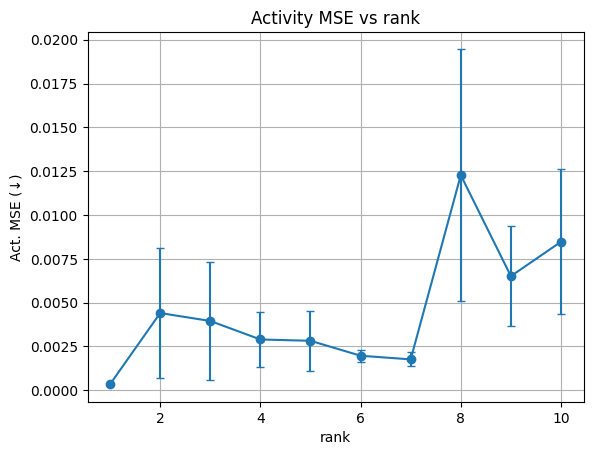

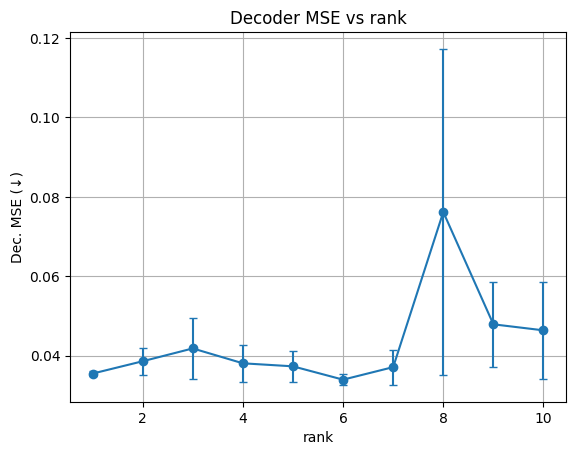

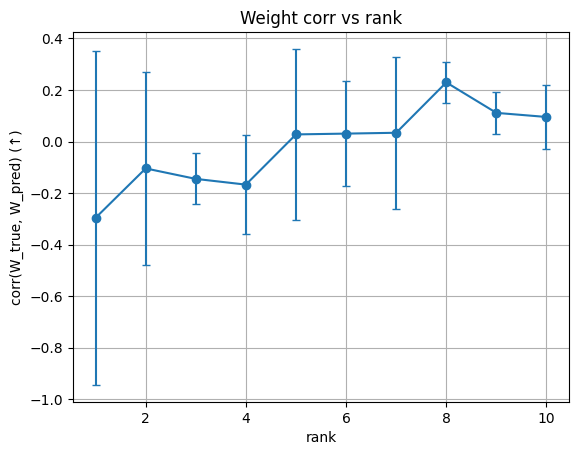

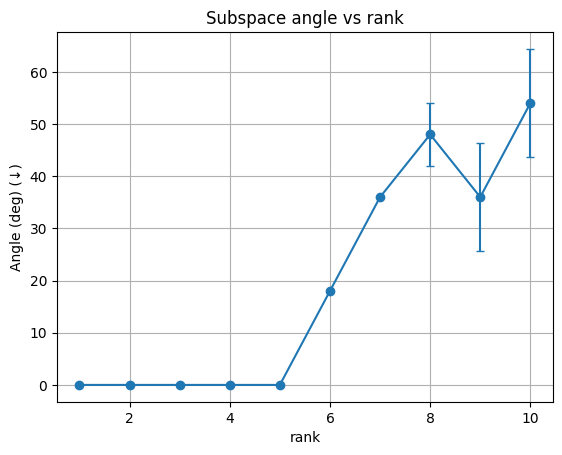

   rank  act_mse_mean  act_mse_sem  dec_mse_mean  dec_mse_sem  w_corr_mean  \
0     1      0.000345     0.000038      0.035486     0.000590    -0.296186   
1     2      0.004407     0.003717      0.038591     0.003370    -0.104376   
2     3      0.003955     0.003351      0.041820     0.007609    -0.145046   
3     4      0.002899     0.001571      0.038072     0.004646    -0.167284   
4     5      0.002825     0.001703      0.037310     0.003985     0.027655   
5     6      0.001973     0.000332      0.033953     0.001325     0.030763   
6     7      0.001765     0.000394      0.037111     0.004405     0.034032   
7     8      0.012273     0.007202      0.076171     0.041074     0.229501   
8     9      0.006511     0.002862      0.047890     0.010674     0.111262   
9    10      0.008473     0.004141      0.046374     0.012221     0.095362   

   w_corr_sem   ang_mean    ang_sem  
0    0.648675   0.000631   0.000158  
1    0.375063   0.000984   0.000190  
2    0.098931   0.000536   

In [2]:
ranks = list(range(1, 11))
df_raw, df_agg = rank_sweep(ranks, seeds=(0,1,2), epochs=300, verbose=False)
print(df_agg)